# Stacking

In [1]:
!pip install -U pandas-profiling
!pip install markupsafe==2.0.1
!pip install catboost
!pip install wandb
!pip install editdistance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 262 kB 4.9 MB/s 
     |████████████████████████████████| 4.7 MB 70.2 MB/s 
     |████████████████████████████████| 62 kB 2.1 MB/s 
     |████████████████████████████████| 102 kB 16.5 MB/s 
     |████████████████████████████████| 596 kB 60.3 MB/s 
     |████████████████████████████████| 690 kB 45.6 MB/s 
     |████████████████████████████████| 11.1 MB 34.9 MB/s 
     |████████████████████████████████| 812 kB 60.4 MB/s 
     |████████████████████████████████| 38.1 MB 315 kB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=7886b47062e843b464cbed1af0045bd81a53f9e9af533fd9ceff29e4fb9e099b
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295206 sha256=4a9aab2fba1c79a1060aff8ce

In [2]:
import os
import random
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import Lars, LassoLars, OrthogonalMatchingPursuit
from sklearn.linear_model import BayesianRidge, ARDRegression, PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor, TheilSenRegressor, HuberRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import re
import editdistance

import warnings
warnings.filterwarnings('ignore')

import argparse
import wandb
wandb.init(project="DACON_235901", name="stacking")

parser = argparse.ArgumentParser(description="stacking")
parser.add_argument('--best_n', default=8, type=int)
parser.add_argument('--scaler', default="standard", type=str) # standard or minmax
parser.add_argument('--cv', default=10, type=int)
parser.add_argument('--seed', default=1011, type=int)
args = parser.parse_args('')

wandb.config.update(args)

best_n = args.best_n
scaler = args.scaler
cv = args.cv
seed = args.seed

if scaler == "standard":
    scaler=StandardScaler()
elif scaler == "minmax":
    scaler=MinMaxScaler()

def set_seeds(seed=seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

set_seeds()

train = pd.read_csv("/content/drive/MyDrive/DACON-Basic/235901_중고차 가격 예측 경진대회/data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/DACON-Basic/235901_중고차 가격 예측 경진대회/data/test.csv")

train.head()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000


### Pandas Profiling

In [3]:
pr = train.profile_report()
pr

Output hidden; open in https://colab.research.google.com to view.

## Preprocessing

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1015 non-null   int64 
 1   title         1015 non-null   object
 2   odometer      1015 non-null   int64 
 3   location      1015 non-null   object
 4   isimported    1015 non-null   object
 5   engine        1015 non-null   object
 6   transmission  1015 non-null   object
 7   fuel          1015 non-null   object
 8   paint         1015 non-null   object
 9   year          1015 non-null   int64 
 10  target        1015 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 87.4+ KB


In [5]:
train.describe()

,id,odometer,year,target
count,1015.000000,1015.000000,1015.000000,1.015000e+03
mean,507.000000,116842.121182,2008.385222,8.243204e+06
std,293.149564,105162.545836,35.592123,1.239567e+07
min,0.000000,0.000000,1217.000000,4.000000e+05
25%,253.500000,55918.000000,2006.000000,2.535000e+06
50%,507.000000,94972.000000,2010.000000,4.215000e+06
75%,760.500000,153224.000000,2014.000000,8.927500e+06
max,1014.000000,987322.000000,2020.000000,1.500150e+08


In [6]:
train.describe(include="object")

,title,location,isimported,engine,transmission,fuel,paint
count,1015,1015,1015,1015,1015,1015,1015
unique,203,13,3,8,2,2,76
top,Toyota Camry,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Black
freq,129,792,744,618,965,970,292


In [7]:
def TargetEncoder(variable, statistics, train, test):
    if statistics=="mean":
        target_dict = dict(train.groupby(by=variable).mean()["target"])
    elif statistics=="median":
        target_dict = dict(train.groupby(by=variable).median()["target"])
    elif statistics=="ordinal":
        target_dict = dict(train.groupby(by=variable).mean()["target"])
        target_dict = dict(pd.Series(np.arange(1, len(target_dict)+1), index=pd.Series(target_dict).sort_values().index))

    train[variable] = [target_dict[k] for k in train[variable]]

    temp=[]
    for k in test[variable]:
        if k in target_dict:
            temp.append(target_dict[k])
        else:
            if statistics=="mean":
                temp.append(np.mean(list(target_dict.values())))
            elif statistics=="median":
                temp.append(np.median(list(target_dict.values())))

    test[variable] = temp

    print(target_dict)

    return train, test

### target

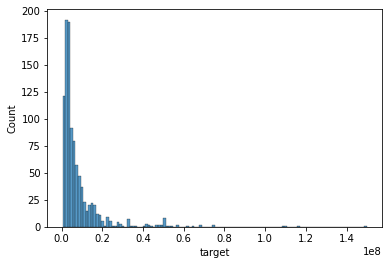

In [8]:
sns.histplot(train["target"])
plt.show()

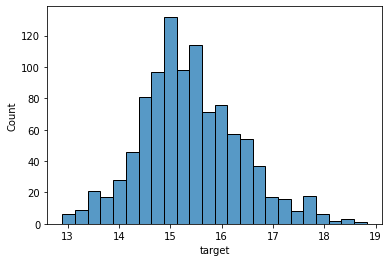

In [9]:
train["target"] = np.log(train["target"])
sns.histplot(train["target"])
plt.show()

### odometer

In [10]:
odometer_median = train["odometer"].median()

train["odometer"] = train["odometer"].replace(0, odometer_median)
test["odometer"] = test["odometer"].replace(0, odometer_median)

train["odometer"].min(), test["odometer"].min()

(10, 38)

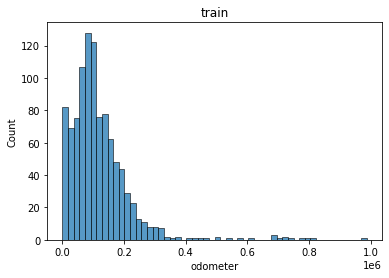

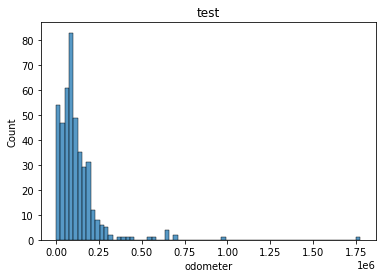

In [11]:
sns.histplot(train["odometer"])
plt.title("train")
plt.show()

sns.histplot(test["odometer"])
plt.title("test")
plt.show()

### year

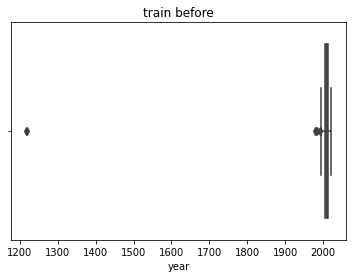

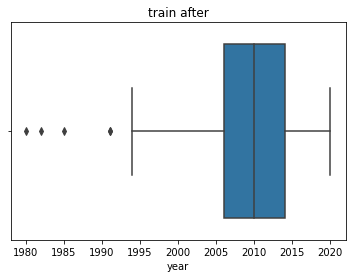

In [12]:
sns.boxplot(x="year", data=train)
plt.title("train before")
plt.show()

train = train[train["year"]>1900]

sns.boxplot(x="year", data=train)
plt.title("train after")
plt.show()

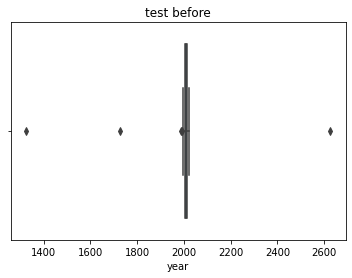

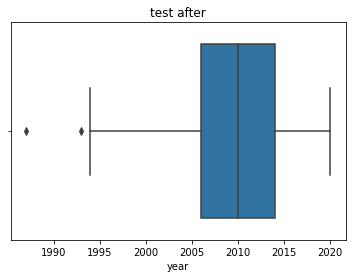

In [13]:
sns.boxplot(x="year", data=test)
plt.title("test before")
plt.show()

test["year"] = test["year"].apply(lambda x : train["year"].median() if x<1900 else x)
test["year"] = test["year"].apply(lambda x : train["year"].median() if x>2022 else x)

sns.boxplot(x="year", data=test)
plt.title("test after")
plt.show()

### title

In [14]:
def title(df):
    df["brand"] = df["title"].apply(lambda x : x.split(" ")[0])
    return df

train = title(train)
test = title(test)

train.head()

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,brand
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,16.430348,Toyota
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,17.312473,Toyota
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,16.109559,Land
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,15.154451,Lexus
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,15.814961,Toyota


In [15]:
target_dict = dict(train.groupby(by="title").mean()["target"])

bins=20
target_dict = dict(pd.cut(pd.Series(target_dict), bins, labels=range(1, bins+1)))

train["title"] = [target_dict[k] for k in train["title"]]

temp=[]
for k in test["title"]:
    if k in target_dict:
        temp.append(target_dict[k])
    else:
        if "title" != "title":
            temp.append(np.mean(list(target_dict.values())))
        else:
            min = 30
            for s in list(target_dict.keys()):
                d = editdistance.eval(k, s)
                if min > d:
                    idx = s
                    min = d
            temp.append(target_dict[idx])

test["title"] = temp

len(target_dict)

201

In [16]:
target_dict = dict(train.groupby(by="brand").mean()["target"])

bins=20
target_dict = dict(pd.qcut(pd.Series(target_dict), bins, labels=range(1, bins+1)))

train["brand"] = [target_dict[k] for k in train["brand"]]

temp=[]
for k in test["brand"]:
    if k in target_dict:
        temp.append(target_dict[k])
    else:
        temp.append(np.mean(list(target_dict.values())))

test["brand"] = temp

len(target_dict)

41

### location

In [17]:
def location(df):
    df["location"] = df["location"].apply(lambda x : x.strip().lower())
    df["location"] = df["location"].apply(lambda x : "lagos" if "lagos" in x else x)
    df["location"] = df["location"].apply(lambda x : "lagos" if "mushin" in x else x)
    df["location"] = df["location"].apply(lambda x : "abuja" if "abuja" in x else x)
    df["location"] = df["location"].apply(lambda x : "abuja" if "fct" in x else x)
    df["location"] = df["location"].apply(lambda x : "ogun" if "ogun" in x else x)
    df["location"] = df["location"].apply(lambda x : "abia" if "abia" in x else x)
    df["location"] = df["location"].apply(lambda x : "other" if x not in ["lagos", "abuja", "ogun", "abia"] else x)
    return df

In [18]:
train = location(train)
train["location"].value_counts()

lagos    829
abuja    149
ogun      27
other      6
abia       2
Name: location, dtype: int64

In [19]:
test = location(test)
test["location"].value_counts()

lagos    355
abuja     69
ogun      10
other      1
abia       1
Name: location, dtype: int64

In [20]:
train, test = TargetEncoder("location", "median", train ,test)

{'abia': 14.356656727864781, 'abuja': 15.14125841921613, 'lagos': 15.35559839226358, 'ogun': 14.74570419500742, 'other': 14.734611378426322}


### isimported

In [21]:
train["isimported"].value_counts()

Foreign Used    744
Locally used    246
New              23
Name: isimported, dtype: int64

In [22]:
test["isimported"].value_counts()

Foreign Used    321
Locally used     97
New              18
Name: isimported, dtype: int64

In [23]:
train, test = TargetEncoder("isimported", "mean", train, test)

{'Foreign Used': 15.573673127366614, 'Locally used': 14.631036709164453, 'New ': 17.2278246254569}


### engine

In [24]:
# def engine(df):
#     p1 = re.compile('[(]\D')
#     p2 = re.compile('\d*[)]')
#     df["engine_1"] = df["engine"].apply(lambda x : p1.search(x)[0][1:])
#     df["engine_2"] = df["engine"].apply(lambda x : p2.search(x)[0][:-1]).astype("int")
#     df["engine_1"] = df["engine_1"].apply(lambda x : "I" if x == "H" else x)
#     return df

In [25]:
train["engine"].value_counts()

4-cylinder(I4)    617
6-cylinder(V6)    221
6-cylinder(I6)    118
8-cylinder(V8)     49
3-cylinder(I3)      3
4-cylinder(H4)      2
5-cylinder(I5)      2
2-cylinder(I2)      1
Name: engine, dtype: int64

In [26]:
test["engine"].value_counts()

4-cylinder(I4)      278
6-cylinder(V6)       89
6-cylinder(I6)       44
8-cylinder(V8)       21
5-cylinder(I5)        1
2-cylinder(I2)        1
12-cylinder(V12)      1
3-cylinder(I3)        1
Name: engine, dtype: int64

In [27]:
train = train.replace({
    '2-cylinder(I2)' : 1,
    '3-cylinder(I3)' : 1,
    '4-cylinder(I4)' : 1,
    '5-cylinder(I5)' : 1,
    '6-cylinder(I6)' : 1,
    '6-cylinder(V6)' : 2,
    '4-cylinder(H4)' : 3,
    '8-cylinder(V8)' : 3,
    '12-cylinder(V12)' : 4,
})

test = test.replace({
    '2-cylinder(I2)' : 1,
    '3-cylinder(I3)' : 1,
    '4-cylinder(I4)' : 1,
    '5-cylinder(I5)' : 1,
    '6-cylinder(I6)' : 1,
    '6-cylinder(V6)' : 2,
    '4-cylinder(H4)' : 3,
    '8-cylinder(V8)' : 3,
    '12-cylinder(V12)' : 4,
})

### transmission

In [28]:
train["transmission"].value_counts()

automatic    965
manual        48
Name: transmission, dtype: int64

In [29]:
test["transmission"].value_counts()

automatic    414
manual        22
Name: transmission, dtype: int64

In [30]:
train, test = TargetEncoder("transmission", "median", train, test)

{'automatic': 15.249403897883443, 'manual': 15.568184515757896}


### fuel

In [31]:
train["fuel"].value_counts()

petrol    970
diesel     43
Name: fuel, dtype: int64

In [32]:
test["fuel"].value_counts()

petrol    416
diesel     20
Name: fuel, dtype: int64

In [33]:
train, test = TargetEncoder("fuel", "median", train, test)

{'diesel': 15.66238932641341, 'petrol': 15.22283228627624}


### paint

In [34]:
def color(x):
    if (x.find('black') >= 0) or \
    (x.find('blac') >= 0):
        x = "black"
    if (x.find('white') >= 0) or \
    (x.find('cream') >= 0) or \
    (x.find('milk') >= 0):
        x = "white"
    if (x.find('silver') >= 0) or \
    (x.find('sliver') >= 0):
        x = "silver"
    if (x.find('grey') >= 0) or \
    (x.find('gray') >= 0) or \
    (x.find('gery') >= 0) or \
    (x.find('ash') >= 0):
        x = "grey"
    if (x.find('blue') >= 0) or \
    (x.find('purple') >= 0) or \
    (x.find('indigo ink pearl') >= 0):
        x = "blue"
    if (x.find('red') >= 0) or \
    (x.find('wine') >= 0) or \
    (x.find('whine') >= 0) or \
    (x.find('maroon') >= 0) or \
    (x.find('orange') >= 0):
        x = "red"
    if (x.find('gold') >= 0) or \
    (x.find('golf') >= 0) or \
    (x.find('yellow') >= 0):
        x = "gold"
    if x.find('green') >= 0:
        x = "green"
    if (x.find('brown') >= 0) or \
    (x.find('beige') >= 0):
        x = "brown"
    return x

def paint(df):
    df["paint"] = df["paint"].apply(lambda x : x.strip().lower())
    df["paint"] = df["paint"].apply(lambda x : color(x))
    return df

In [35]:
train = paint(train)
train["paint"].value_counts()

black     315
grey      165
white     154
silver    117
blue      106
red        72
gold       45
green      21
brown      18
Name: paint, dtype: int64

In [36]:
test = paint(test)
test["paint"].value_counts()

black     126
silver     67
white      64
grey       64
red        39
blue       38
green      16
gold       15
brown       7
Name: paint, dtype: int64

In [37]:
train, test = TargetEncoder("paint", "median", train, test)

{'black': 15.52298221066974, 'blue': 15.08240955762138, 'brown': 15.404693698729268, 'gold': 14.919113373213595, 'green': 14.868078908130977, 'grey': 15.149194968811868, 'red': 15.133244039657185, 'silver': 15.0139681816021, 'white': 15.640217213386848}


### Correlation

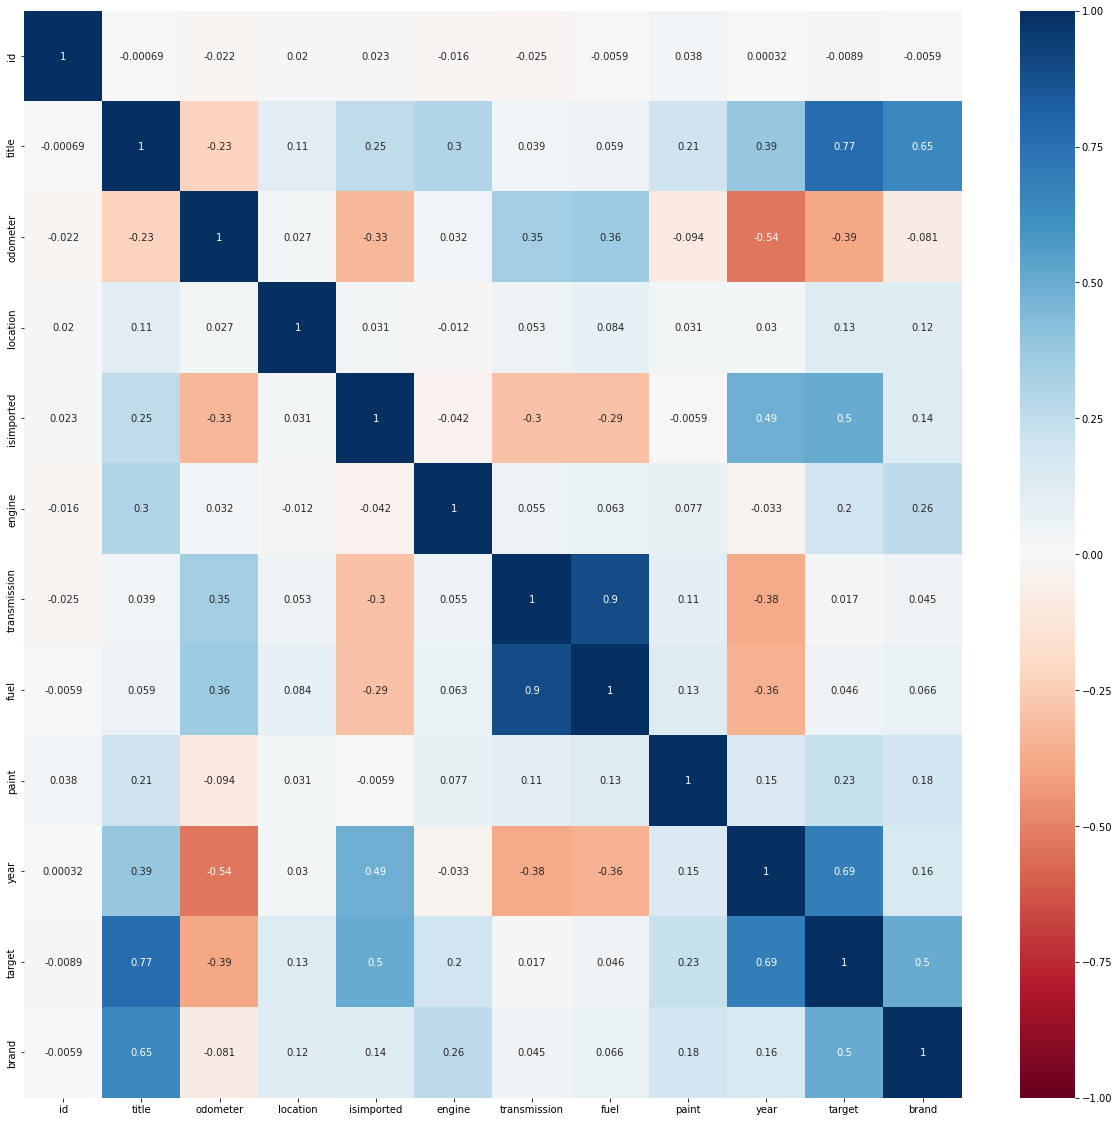

In [38]:
plt.figure(figsize=(21,20))
sns.heatmap(train.corr(), vmin=-1, vmax=1, cmap='RdBu', annot=True)
plt.show()

In [39]:
train = train.drop(["id", "transmission"], axis=1)
test = test.drop(["id", "transmission"], axis=1)

train.head()

,title,odometer,location,isimported,engine,fuel,paint,year,target,brand
0,9,18277,15.355598,15.573673,1,15.222832,15.133244,2016,16.430348,9
1,15,10,15.355598,17.227825,1,15.222832,15.522982,2019,17.312473,9
2,14,83091,15.355598,15.573673,2,15.222832,15.133244,2012,16.109559,19
3,9,91524,15.355598,15.573673,1,15.222832,15.149195,2007,15.154451,15
4,10,94177,15.355598,15.573673,2,15.222832,15.133244,2010,15.814961,9


## Training

### Modelling

In [40]:
estimator1 = LinearRegression(n_jobs=-1)
estimator2 = Ridge(random_state=seed)
estimator3 = Lasso(random_state=seed)
estimator4 = ElasticNet(random_state=seed)
estimator5 = Lars(random_state=seed)
estimator6 = LassoLars(random_state=seed)
estimator7 = OrthogonalMatchingPursuit()
estimator8 = BayesianRidge()
estimator9 = ARDRegression()
estimator10 = PassiveAggressiveRegressor(random_state=seed)
estimator11 = RANSACRegressor(random_state=seed)
estimator12 = TheilSenRegressor(n_jobs=-1, random_state=seed)
estimator13 = HuberRegressor()
estimator14 = KernelRidge()
estimator15 = SVR()
estimator16 = KNeighborsRegressor(n_jobs=-1)
estimator17 = DecisionTreeRegressor(random_state=seed)
estimator18 = ExtraTreeRegressor(random_state=seed)
estimator19 = BaggingRegressor(n_jobs=-1, random_state=seed)
estimator20 = ExtraTreesRegressor(n_jobs=-1, random_state=seed)
estimator21 = RandomForestRegressor(n_jobs=-1, random_state=seed)
estimator22 = AdaBoostRegressor(random_state=seed)
estimator23 = GradientBoostingRegressor(random_state=seed)
estimator24 = HistGradientBoostingRegressor(random_state=seed)
estimator25 = XGBRegressor(n_jobs=-1, random_state=seed)
estimator26 = LGBMRegressor(n_jobs=-1, random_state=seed)
estimator27 = CatBoostRegressor(verbose=False, random_state=seed)
estimator28 = MLPRegressor(random_state=seed)

### Utils

In [41]:
def get_stacking_ml_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n, y_train_n)):
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        test_pred[:, folder_counter] = model.predict(X_test_n)
        
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    return train_fold_pred, test_pred_mean

In [42]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

### Validation - all

In [43]:
X = train.drop(["target"], axis=1)
y = train.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

X_train.shape, X_test.shape

((759, 9), (254, 9))

In [44]:
%%time

base_ml = [
           estimator1, estimator2, estimator3, estimator4, estimator5, estimator6, estimator7,
           estimator8, estimator9, estimator10, estimator11, estimator12, estimator13, estimator14,
           estimator15, estimator16, estimator17, estimator18, estimator19, estimator20, estimator21,
           estimator22, estimator23, estimator24, estimator25, estimator26, estimator27, estimator28
           ]

meta_ml_X_train=[]
meta_ml_X_test=[]
for estimator in base_ml:
    temp_X_train, temp_X_test = get_stacking_ml_datasets(estimator, X_train, y_train.values, X_test, cv)
    meta_ml_X_train.append(temp_X_train)
    meta_ml_X_test.append(temp_X_test)
    
meta_ml_X_train=np.hstack(meta_ml_X_train)
meta_ml_X_test=np.hstack(meta_ml_X_test)

meta_ml_X_train.shape, meta_ml_X_test.shape

[06:33:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:33:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:33:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:33:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:33:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:33:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:33:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:33:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [45]:
scores={}
for idx, estimator in enumerate(base_ml):
    scores[idx]=NMAE(np.exp(y_test).round().astype("int"), np.exp(estimator.predict(X_test)).round().astype("int"))
sorted(scores.items(), key = lambda item : item[1])

[(19, 0.2704894563128618),
 (20, 0.27760792643609267),
 (26, 0.27837161080588785),
 (25, 0.2807262961318692),
 (23, 0.2827581135685727),
 (18, 0.28855524214042255),
 (22, 0.30077569209261323),
 (14, 0.3011319252766604),
 (24, 0.30521556965613694),
 (10, 0.3146449647720151),
 (12, 0.3247759721204885),
 (15, 0.3423330594161233),
 (7, 0.34674365042106475),
 (1, 0.3473809428543874),
 (0, 0.34787584934925403),
 (4, 0.34787584934925403),
 (8, 0.3499336684634679),
 (21, 0.3512385478827741),
 (16, 0.38808702331165645),
 (17, 0.39310387944879677),
 (11, 0.4487667790232022),
 (9, 0.47579660039783095),
 (6, 0.48458436875898503),
 (3, 0.6066773810539091),
 (2, 0.6874998627757138),
 (5, 0.6874998627757138),
 (13, 0.9999997662006356),
 (27, 7.4733387957366695)]

In [46]:
model_idx=np.array(sorted(scores.items(), key = lambda item : item[1]))[:best_n, 0]
best_ml=[value for i, value in enumerate(base_ml) if i in model_idx]
best_ml

[SVR(),
 BaggingRegressor(n_jobs=-1, random_state=1011),
 ExtraTreesRegressor(n_jobs=-1, random_state=1011),
 RandomForestRegressor(n_jobs=-1, random_state=1011),
 GradientBoostingRegressor(random_state=1011),
 HistGradientBoostingRegressor(random_state=1011),
 LGBMRegressor(random_state=1011),

In [47]:
meta_clf=LinearRegression()
meta_clf.fit(meta_ml_X_train, y_train)
prediction=meta_clf.predict(meta_ml_X_test)

nmae_all=NMAE(np.exp(y_test).round().astype("int"), np.exp(prediction).round().astype("int"))
print("nmae_all: ", nmae_all)

wandb.log({'NMAE_all': nmae_all})

nmae_all:  0.2678314535067381


### Validation - best

In [48]:
%%time

meta_ml_X_train=[]
meta_ml_X_test=[]
for estimator in best_ml:
    temp_X_train, temp_X_test = get_stacking_ml_datasets(estimator, X_train, y_train.values, X_test, cv)
    meta_ml_X_train.append(temp_X_train)
    meta_ml_X_test.append(temp_X_test)
    
meta_ml_X_train=np.hstack(meta_ml_X_train)
meta_ml_X_test=np.hstack(meta_ml_X_test)

meta_ml_X_train.shape, meta_ml_X_test.shape

CPU times: user 29.3 s, sys: 2.14 s, total: 31.4 s
Wall time: 31 s


In [49]:
meta_clf = LinearRegression()
meta_clf.fit(meta_ml_X_train, y_train)
prediction = meta_clf.predict(meta_ml_X_test)

nmae_best = NMAE(np.exp(y_test).round().astype("int"), np.exp(prediction).round().astype("int"))
print("nmae_best: ", nmae_best)

wandb.log({'NMAE_best': nmae_best})

nmae_best:  0.27200479873195726


## Inference

In [50]:
X_train = train.drop(["target"], axis=1)
y_train = train.target
X_test = test

X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

X_train.shape, X_test.shape

((1013, 9), (436, 9))

In [51]:
%%time

meta_ml_X_train=[]
meta_ml_X_test=[]
for estimator in best_ml:
    temp_X_train, temp_X_test = get_stacking_ml_datasets(estimator, X_train, y_train.values, X_test, cv)
    meta_ml_X_train.append(temp_X_train)
    meta_ml_X_test.append(temp_X_test)
    
meta_ml_X_train=np.hstack(meta_ml_X_train)
meta_ml_X_test=np.hstack(meta_ml_X_test)

meta_ml_X_train.shape, meta_ml_X_test.shape

CPU times: user 28.2 s, sys: 2.34 s, total: 30.5 s
Wall time: 22.9 s


In [52]:
meta_clf = LinearRegression()
meta_clf.fit(meta_ml_X_train, y_train)
prediction = meta_clf.predict(meta_ml_X_test)

submission = pd.read_csv("/content/drive/MyDrive/DACON-Basic/235901_중고차 가격 예측 경진대회/data/sample_submission.csv")
submission["target"] = np.exp(prediction).round().astype("int")
submission.to_csv("/content/drive/MyDrive/DACON-Basic/235901_중고차 가격 예측 경진대회/submission.csv", index=False)

In [53]:
test = pd.read_csv("/content/drive/MyDrive/DACON-Basic/235901_중고차 가격 예측 경진대회/data/test.csv")
answer = pd.read_csv("/content/drive/MyDrive/DACON-Basic/235901_중고차 가격 예측 경진대회/data/answer.csv")
answer = pd.merge(test, answer, how="inner", left_on=list(test.columns[1:]), right_on=list(test.columns[1:]))["price"]

nmae_cheet=NMAE(answer, np.exp(prediction).round().astype("int"))
print("nmae_cheet: ", nmae_cheet)

wandb.log({'NMAE_cheet': nmae_cheet})

nmae_cheet:  0.28240505660142284
